In [1]:
import sys
import os 
sys.path.append(os.path.dirname(os.getcwd()) + "/src/")

import numpy as np
import torch
import torch.nn as nn
import omegaconf

from eval.utils import encode_features
from model.model import Model
from model.config import ModelConfig
from dataloader.ssl_dataloader import get_dataset
from dataloader.transform import get_weak_augmentation
from matplotlib import pyplot as plt
import copy
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

## Boilerplate needed for notebooks

In [29]:
# CIFAR10
# ckpt_path = "../results/cifar10_vi-thresh_dict32_proj/checkpoint_epoch999.pt"
# cfg_path = "../results/cifar10_vi-thresh_dict32_proj/config.yaml"
# ckpt_path = "../results/vi-thresh_dict32_kl1e-5_proj_to10_05-18-2023_14-31-39/checkpoints/checkpoint_epoch999.pt"
# cfg_path = "../results/vi-thresh_dict32_kl1e-5_proj_to10_05-18-2023_14-31-39/.hydra/config.yaml"

# STL 10
# ckpt_path = "../results/stl10_vi_dict64_kl1e-5_proj_to10_05-17-2023_20-54-47/checkpoints/checkpoint_epoch999.pt"
# cfg_path = "../results/stl10_vi_dict64_kl1e-5_proj_to10_05-17-2023_20-54-47/.hydra/config.yaml"

# TIN
ckpt_path = "../results/tin_vi_dict128_kl1e-5_proj_to10_05-18-2023_03-25-42/checkpoints/checkpoint_epoch999.pt"
cfg_path = "../results/tin_vi_dict128_kl1e-5_proj_to10_05-18-2023_03-25-42/.hydra/config.yaml"

device_idx = [0]
# Set the default device
default_device = torch.device("cuda:0")
# Load config
cfg = omegaconf.OmegaConf.load(cfg_path)
cfg.model_cfg.backbone_cfg.load_backbone = None

# CUSTOM CONFIG FOR THIS RUN #

# Load model
default_model_cfg = ModelConfig()
model = Model.initialize_model(cfg.model_cfg, cfg.dataloader_cfg.dataset_cfg.dataset_name, device_idx)
state_dict = torch.load(ckpt_path, map_location=default_device)
model.load_state_dict(state_dict['model_state'], strict=False)
# Manually override directory for dataloaders
if 'tin' in ckpt_path:
    cfg.dataloader_cfg.dataset_cfg.dataset_dir = "../datasets/tiny-imagenet-200"
    num_classes = 200
else:
    cfg.dataloader_cfg.dataset_cfg.dataset_dir = "../datasets"
    num_classes = 10
cfg.dataloader_cfg.train_batch_size = 500
# Load dataloaders
dataset = get_dataset(cfg.dataloader_cfg)
train_dataloader = dataset.eval_dataloader
test_dataloader = dataset.val_dataloader
# Get encoding of entire dataset
train_eval_input = encode_features(model, train_dataloader, default_device)
test_eval_input = encode_features(model, test_dataloader, default_device)

# Load transport operators
backbone = model.backbone.backbone_network
transop, coeff_enc = (None, None)
if model.contrastive_header.transop_header is not None:
    transop = model.contrastive_header.transop_header.transop
    coeff_enc = model.contrastive_header.transop_header.coefficient_encoder

# Eval values
x, z, y = train_eval_input.x, train_eval_input.feature_list, train_eval_input.labels
x_test, z_test, y_test = test_eval_input.x, test_eval_input.feature_list, test_eval_input.labels

Using cache found in /storage/home/hcoda1/0/kfallah3/.cache/torch/hub/pytorch_vision_v0.10.0


TypeError: Invalid shape (32, 3, 32) for image data

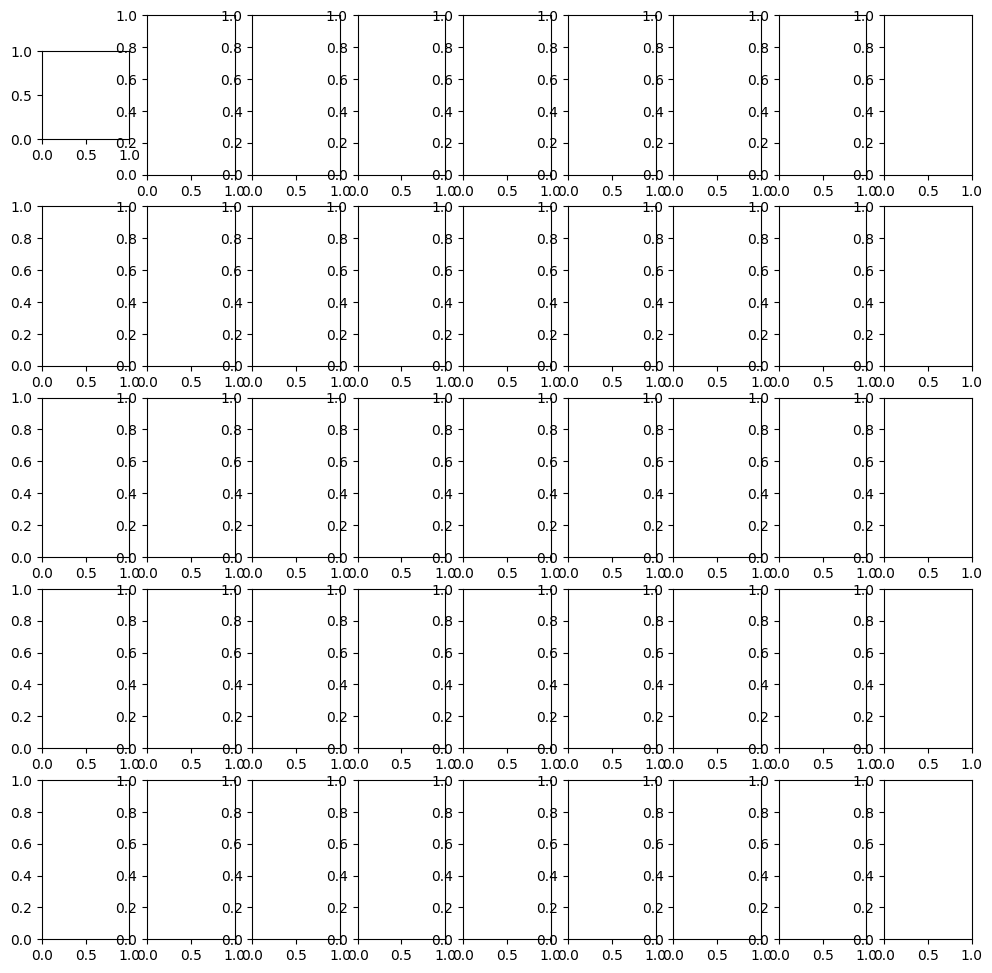

In [33]:
aug_idx = 7
num_im = 5
num_augs = 8
aug_list = torch.zeros((num_im, num_augs, 512))

for i in range(num_im):
    for j in range(num_augs):
        z0 = z[aug_idx+i].to(default_device)
        c = coeff_enc.prior_sample(z0.unsqueeze(0).detach()).squeeze(0)
        zu_aug = transop(z0, c)
        aug_list[i,j] = zu_aug.detach().cpu()

from sklearn.metrics import pairwise_distances

x_im = torch.tensor(train_dataloader.dataset.data).permute(0, 2, 3, 1)
fig, ax = plt.subplots(nrows=num_im, ncols=num_augs+1, figsize=(12, 12))

for k in range(num_im):
    pw_dist = pairwise_distances(z, aug_list[k])
    nn_idx = torch.argmin(torch.tensor(pw_dist), dim=0)
    ax[k, 0].imshow(x_im[aug_idx + k])
    for i in range(num_augs):
        ax[k,i+1].imshow(x_im[nn_idx[i]])
[axi.set_axis_off() for axi in ax.ravel()]
plt.subplots_adjust(wspace=0.0, hspace=0.0)
print()

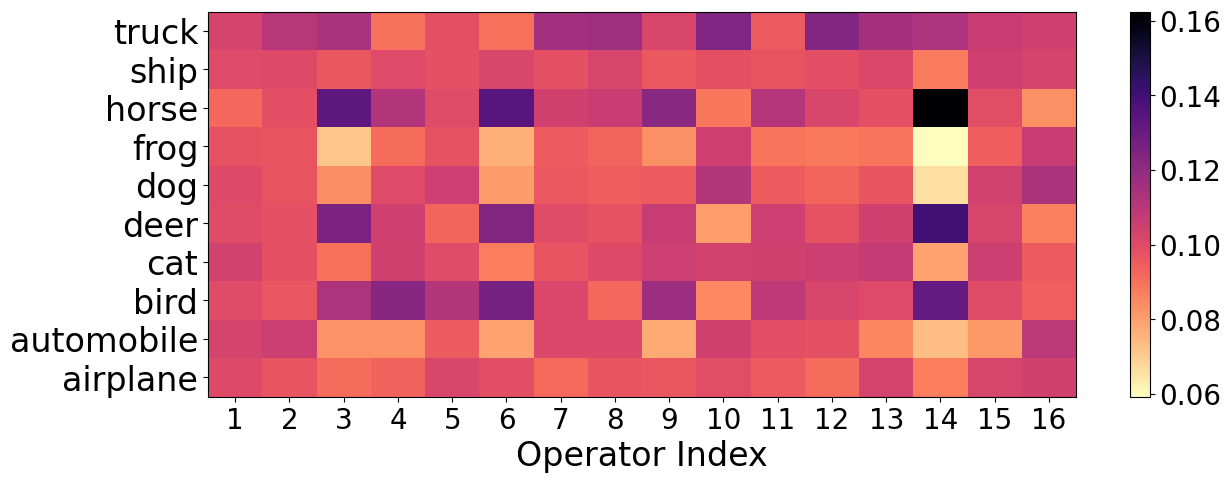

In [6]:
f_norm = (transop.psi.reshape(len(transop.psi), -1)**2).sum(-1)
op_idx = torch.arange(16)
#op_idx = torch.tensor([1,2,21,23,26,29,30,31,32,42,48,58,62])
#op_idx = torch.argsort(f_norm)[-35:-3]
#print(op_idx)

num_sample = 1
c_list = torch.zeros((len(z), len(op_idx)))
for i in range(len(z) // 500):
    z0 = z[i*500:(i+1)*500].to(default_device)
    for j in range(num_sample):
        c = coeff_enc.prior_sample(z0.detach())
        c_list[i*500:(i+1)*500] += c[:, op_idx].abs().detach().cpu() / num_sample
        #prior_params, _ = coeff_enc.get_prior_params(z0.detach())
        #c_list[i*500:(i+1)*500] = prior_params['shift'][:, op_idx].detach().cpu()

cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
#stl10_labels = ["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"]
scale_per_class = np.zeros((10, len(op_idx)))
for i in range(10):
    idx = y == i
    scale_per_class[i] = c_list[idx].mean(dim=0)

scale_per_class = scale_per_class / scale_per_class.sum(0)[None, :]

plt.figure(figsize=(14, 5))
plt.pcolormesh(scale_per_class, cmap='magma_r')
plt.yticks(np.arange(10)+0.5, cifar10_labels, fontsize=24)
plt.xticks(np.arange(len(op_idx))+0.5, op_idx.long().detach().cpu().numpy()+1, fontsize=20)
plt.xlabel("Operator Index", fontsize=24)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)

# Transop Prior Samples

In [30]:
import torch.nn.functional as F

num_samp = 20
baseline_acc_list = []
prior_acc_list = []
hp_acc_list = []
rand_acc_list = []

for i in range(num_samp):
    train_eval_input = encode_features(model, train_dataloader, default_device)
    test_eval_input = encode_features(model, test_dataloader, default_device)
    _, z, y = train_eval_input.x, train_eval_input.feature_list, train_eval_input.labels
    _, z_test, y_test = test_eval_input.x, test_eval_input.feature_list, test_eval_input.labels

    # Fit linear classifier
    backbone_feat_dim = train_eval_input.feature_list.shape[1]
    clf = nn.Linear(backbone_feat_dim, num_classes).to(default_device)

    lr_start, lr_end = 1e-2, 1e-6
    gamma = (lr_end / lr_start) ** (1 / 500)
    optimizer = torch.optim.Adam(clf.parameters(), lr=lr_start, weight_decay=5e-6)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    criterion = nn.CrossEntropyLoss().to(default_device)

    z_train, y_train = z.to(default_device), y.to(default_device)
    z_val, y_val = z_test.to(default_device), y_test.to(default_device)

    for e in range(500):
        perm = torch.randperm(len(z_train)).view(-1, 1000)
        for idx in perm:
            optimizer.zero_grad()
            criterion(clf(z_train[idx]), y_train[idx]).backward()
            optimizer.step()
        scheduler.step()
    y_pred = clf(z_val)
    pred_top = y_pred.topk(max([1, 5]), 1, largest=True, sorted=True).indices
    acc = {t: (pred_top[:, :t] == y_val[..., None]).float().sum(1).mean().cpu().item() for t in [1, 5]}
    baseline_acc_list.append(acc[1])

    prior_total = 0
    prior_correct = 0
    rand_total = 0
    rand_correct = 0
    for k in range(len(z_val) // 1000):
        z_batch, y_batch = z_val[k*1000:(k+1)*1000], y_val[k*1000:(k+1)*1000]
        prior_params, hyperprior_params = coeff_enc.get_prior_params(z_batch)
        c = coeff_enc.prior_sample(z_batch.detach(), distribution_params=prior_params)
        z_aug = transop(z_batch, c)
        y_pred = clf(z_aug)
        conf = torch.softmax(y_pred, dim=-1)[y_batch]
    
        y_pred = y_pred.topk(1, 1, largest=True, sorted=True).indices[:, 0]
        prior_total += len(y_pred)
        prior_correct += (y_pred == y_batch).sum().item()
        dist = torch.sqrt(((z_batch - z_aug)**2).sum(dim=-1))
        #dist = (z_batch - z_aug).abs()
        n = torch.randn(z_aug.shape, device=default_device)
        n = (n / torch.norm(n, dim=-1).unsqueeze(-1)) * dist.unsqueeze(-1)
        n = n * dist.unsqueeze(-1)
        z_rand = z_batch + n
        y_pred = clf(z_rand)
        y_pred = y_pred.topk(1, 1, largest=True, sorted=True).indices[:, 0]
        rand_total += len(y_pred)
        rand_correct += (y_pred == y_batch).sum().item()
    prior_acc_list.append(prior_correct / prior_total)
    rand_acc_list.append(rand_correct / rand_total)

    hp_total = 0
    hp_correct = 0
    for k in range(len(z_val) // 1000):
        z_batch, y_batch = z_val[k*1000:(k+1)*1000], y_val[k*1000:(k+1)*1000]
        prior_params, hyperprior_params = coeff_enc.get_prior_params(z_batch)
        c = coeff_enc.prior_sample(z_batch.detach(), distribution_params=hyperprior_params)
        z_aug = transop(z_batch, c)
        y_pred = clf(z_aug)
        conf = torch.softmax(y_pred, dim=-1)[y_batch]
    
        y_pred = y_pred.topk(1, 1, largest=True, sorted=True).indices[:, 0]
        hp_total += len(y_pred)
        hp_correct += (y_pred == y_batch).sum().item()
    hp_acc_list.append(hp_correct / hp_total)


print("Baseline")
print(np.mean(baseline_acc_list) * 100)
print(np.std(baseline_acc_list) * 100)
print("Prior")
print(np.mean(prior_acc_list) * 100)
print(np.std(prior_acc_list) * 100)
print("Hyper-prior")
print(np.mean(hp_acc_list) * 100)
print(np.std(hp_acc_list) * 100)
print("Random")
print(np.mean(rand_acc_list) * 100)
print(np.std(rand_acc_list) * 100)

Baseline
42.46999889612198
0.004472211697780749
Prior
39.70249999999999
0.12672312338322478
Hyper-prior
4.1505
0.11065599848178134
Random
24.240500000000004
0.43067940512636516


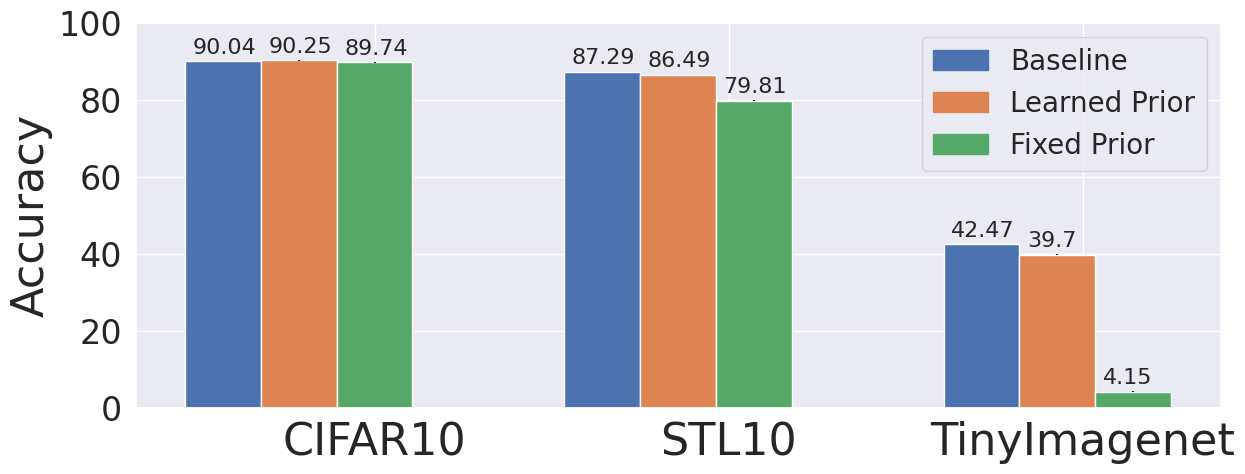

In [39]:
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
sns.set_theme()

# Found via previous exp trials -- see excel sheet for source
plt.figure(figsize=(14, 5))

# loc = np.array([0, 0.75, 1.5, 3.0, 3.75, 4.5, 6.00, 6.75, 7.5])
# baseline_val = np.array([90.04, 90.24, 89.75, 87.21, 87.19, 85.39, 41.58, 40.75, 21.02])
# var = np.array([0, 0.084, 0.09, 0, 0.063, 0.18, 0, 0.14, 0.28])

baseline_mean = [90.04, 87.29, 42.47]
baseline_std = [0.01, 0.03, 0.004]

prior_mean = [90.25, 86.49, 39.70]
prior_std = [0.09, 0.07, 0.13]
hp_mean = [89.74, 79.81, 4.15]
hp_std = [0.07, 0.21, 0.11]
rand_mean = [90.03, 87.03, 24.24]
rand_std = [0.05, 0.13, 0.43]

plt.bar([i*5*0.75 for i in range(3)], baseline_mean, width=0.75, yerr=baseline_std)
plt.bar([i*5*0.75 + 0.75 for i in range(3)], prior_mean, width=0.75, yerr=prior_std)
plt.bar([i*5*0.75 + 1.5 for i in range(3)], hp_mean, width=0.75, yerr=hp_std)
#plt.bar([i*5*0.75 + 2.25 for i in range(3)], rand_mean, width=0.75, yerr=rand_std)


for idx in range(len(baseline_mean)):
  plt.text(idx*5*0.75 - 0.3, baseline_mean[idx] + 2, baseline_mean[idx], fontsize=16)
  plt.text(idx*5*0.75 + 0.75 - 0.3, prior_mean[idx] + 2, prior_mean[idx], fontsize=16)
  plt.text(idx*5*0.75 + 1.5 - 0.3, hp_mean[idx] + 2, hp_mean[idx], fontsize=16)

plt.ylabel("Accuracy", fontsize=32)
plt.yticks([0, 20, 40, 60, 80, 100], [0, 20, 40, 60, 80, 100], fontsize=24)
plt.xticks([1.5, 5, 8.5], ["CIFAR10", "STL10", "TinyImagenet"], fontsize=32)

labels = ["Baseline", "Learned Prior", "Fixed Prior"]#, "Random Perturb"]
colors = sns.color_palette()[:3]
handles = [plt.Rectangle((0,0),1,1, color=c) for c in colors]
plt.legend(handles, labels, fontsize=20)